# NLP with Disaster Tweets
- Author: Tim Seidel
- Date: 24.06.2025
### NLP Disaster Tweets Kaggle Mini-Project
The following notebook aims to predict (binary classification) whether a given tweet is about a real disaster or not (1, 0)

1. providing a thorough description of the problem & data, 
2. developing an Exploratory Data Analysis, 
3. building and analyzing multiple model architectures, 
4. performing hyperparameter tuning on these different architectures & showing / analyzing results,
5. and providing a discussion and conclusion. 

### Github Repository: 


### Data Source: 
As part of this project data will be used from the Natural Language Processing with Disaster Tweets Kaggle Project. Specifically, I would like to cite: 
- Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


In [ ]:
# Necessary Import
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import gc, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import re
from nltk.tokenize import TweetTokenizer
import emoji
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.sparse import hstack
from nltk import pos_tag
import keras_tuner as kt
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.models import load_model

## Step 1: Description of Problem, NLP, and Data
"Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data."

#### Step 1.1 Problem Description: 
The goal given the text of a tweet alongside a keywoard and the location the tweet was sent from, is to predict whether the given tweet is about a real disaster or not.
- Real Disaster: 1
- False disaster: 0 

Submissions are evaluated according to the F1 score between the predicted and expected answers. Where F1, precision and recall are calculated as follows: 

$$
F_1 \;=\; 2 \times \frac{\mathrm{precision}\;\times\;\mathrm{recall}}
{\mathrm{precision} + \mathrm{recall}}
$$

$$
\mathrm{precision} \;=\; \frac{TP}{TP + FP}
$$

$$
\mathrm{recall} \;=\; \frac{TP}{TP + FN}
$$

- "True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!" (Howard, et al., 2019)
- "False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false." (Howard, et al., 2019)
- "False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false." (Howard, et al., 2019)

Specifically, the submission file shall consist of two columns: id, and target. 

#### Step 1.2 NLP Description: 
Natural Language Processing is a subfield of AI and linguistics that develops algorithms to transform unstructured text or speach into meaningful numerical representations. An NLP pipeline generally begins by tokenizing input into words or subword units and mapping those tokens to dense vectors - known as embeddings - that capture semantic and syntactic relationships. The embeddings are then processed by machine learning algorithms (RNN, CNN or Transformers) to learn context across sequences. NLP pipelines, when fine-tuned, can achieve human-like performance on translation, summarization, sentiment analysis, etc. 

#### Step 1.3 Data Description: 
The dataset consists of train, test and a sample_submission file. 
- Train: consists of 7613 unique tweets (rows) and 5 columns: id, keyword, location, text, target
- Test: consists of 3263 unique tweets (rows) and 4 columns: id, keyword, location, text

The columns refer to the following: 
- id: "a unique identifier for each tweet" (Howard, et al., 2019)
- text: "the text of the tweet" (Howard, et al., 2019)
- location: "the location the tweet was sent from" (Howard, et al., 2019)
- keyword: "a particular keyword from the tweet" (Howard, et al., 2019)
- target: "in train.csv only, this denotes whether a tweet is about a real disaster (1 or not 0)" (Howard, et al., 2019)

The dataset has been hand-classified and the dataset was created by the compangy figure-eight. 

In [61]:
train = pd.read_csv("/Users/timseidel/Documents/Graduate_Certificate/nlp_disasterTweets/nlp-getting-started/train.csv")
test = pd.read_csv("/Users/timseidel/Documents/Graduate_Certificate/nlp_disasterTweets/nlp-getting-started/test.csv")
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Step 2: Exploratory Data Analysis
"Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?"

#### Step 2.1: Basic Metrics

In [30]:
# Number of Rows and Columns
print("Shape of Train File: ", train.shape)

# Data Types # non-null counts
train.info()

Shape of Train File:  (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [31]:
# Missing Values
missing = train.isna().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Given that there exist missing values it may make sense to input dummy values as part of the data preprocessing step. 

In [32]:
# Duplicate Values:
num_exact_dupl = train.duplicated().sum()
print(f"Exact duplicate rows: {num_exact_dupl}")

# Duplicate Texts
text_dupl = train["text"].duplicated().sum()
print(f"Number of Tweets with duplicate text:  {text_dupl}")
print(train[train.duplicated(subset=["text"], keep=False)][["id", "text","keyword", "location", "target"]].head(10))

Exact duplicate rows: 0
Number of Tweets with duplicate text:  110
      id                                               text  \
40    59  Check these out: http://t.co/rOI2NSmEJJ http:/...   
48    68  Check these out: http://t.co/rOI2NSmEJJ http:/...   
106  156  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...   
115  165  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...   
118  171  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...   
119  172  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...   
147  211  Experts in France begin examining airplane deb...   
164  238  Experts in France begin examining airplane deb...   
610  881                         To fight bioterrorism sir.   
624  898                         To fight bioterrorism sir.   

                 keyword        location  target  
40                ablaze  Live On Webcam       0  
48                ablaze  Live On Webcam       0  
106           aftershock              US       0  
115           aftershock           

Given the above output, there exist 110 tweets with duplicated text and additionally there exists a certain number where the text, keyword, location and target are duplcate values of one another. 

In [33]:
# Count duplicate rows, where "text", "keyword", "location", and "target" are identical
dupl_4Columns = train.duplicated(subset=["text", "keyword", "location", "target"]).sum()
print(f"Number of tweets with duplicate text, keyword, location, and target: {dupl_4Columns}")

Number of tweets with duplicate text, keyword, location, and target: 52


Given there exist 52, it is necessary to drop duplicates and keep only the first occurence.
#### Step 2.2 Drop Duplicates where "text", "keyword", "location", and "target" are identical and keep 1st occurence

In [34]:
train_noDupl = train.drop_duplicates(
    subset=["text", "keyword", "location","target"],
    keep = "first"
).reset_index(drop=True)

# Verify
new_dupl_4columns = train_noDupl.duplicated(subset=["text", "keyword", "location", "target"]).sum()
print(f"Remaining tweets with duplicate text, keyword, location, and target: {new_dupl_4columns}")

Remaining tweets with duplicate text, keyword, location, and target: 0


In [35]:
# Duplicate Texts
text_dupl = train_noDupl["text"].duplicated().sum()
print(f"Number of Tweets with duplicate text:  {text_dupl}")
print(train_noDupl[train_noDupl.duplicated(subset=["text"], keep=False)][["id", "text","keyword", "location", "target"]].head(10))

Number of Tweets with duplicate text:  58
        id                                               text  \
606    881                         To fight bioterrorism sir.   
620    898                         To fight bioterrorism sir.   
1128  1634  Japan on Thursday marks the 70th anniversary o...   
1150  1665  Japan on Thursday marks the 70th anniversary o...   
1166  1689  Warne shocked over Australia's epic collapse a...   
1191  1723  Mmmmmm I'm burning.... I'm burning buildings I...   
1193  1725  @themagickidraps not upset with a rally upset ...   
1195  1727  @_minimehh @cjoyner I must be overlooking the ...   
1196  1728  @fewmoretweets all lives matter. Just not a fa...   
1198  1733  I'm mentally preparing myself for a bomb ass s...   

                  keyword                location  target  
606          bioterrorism                     NaN       1  
620          bioterrorism                     NaN       0  
1128              bombing                     NaN       1  
11

Given the above output, it is clear that there exist tweets with the same text, keyword and location but different target. This could yield to the model learning contraditory signals. 

#### Step 2.3: Highlight duplicates with different target values

In [36]:
# Number of duplicates with differing target values
new_dupl_3columns = train_noDupl.duplicated(subset=["text", "keyword", "location"]).sum()
print(f"Remaining tweets with duplicate text, keyword, location, but different target: {new_dupl_3columns}")
inspect_csv = train_noDupl[train_noDupl.duplicated(subset=["text", "keyword", "location"], keep=False)][["id", "text","keyword", "location", "target"]]
print(inspect_csv)
inspect_csv.to_csv("conflicting_tweets.csv", index=False)

Remaining tweets with duplicate text, keyword, location, but different target: 9
        id                                               text       keyword  \
606    881                         To fight bioterrorism sir.  bioterrorism   
620    898                         To fight bioterrorism sir.  bioterrorism   
2814  4068  .POTUS #StrategicPatience is a strategy for #G...     displaced   
2815  4076  .POTUS #StrategicPatience is a strategy for #G...     displaced   
3957  5662  Who is bringing the tornadoes and floods. Who ...        floods   
3985  5699  Who is bringing the tornadoes and floods. Who ...        floods   
4203  6012  Caution: breathing may be hazardous to your he...     hazardous   
4206  6017  Caution: breathing may be hazardous to your he...     hazardous   
4255  6087  The Prophet (peace be upon him) said 'Save you...      hellfire   
4256  6088  Hellfire is surrounded by desires so be carefu...      hellfire   
4263  6097  The Prophet (peace be upon him) said '

Given that there exist conflicting labels, there are two options with which to handle these: 
- Manual Review and relabel: try to find additional context and decide on the more plausible / correct label. 
- Drop all contradictory tweets: if resolving the conflict is not possible, it is safer to remore both examples than to teach the model contradictory signals

Given that, this is a mini-project and the number of contradictory tweets is 22, I will drop them. 

#### 2.4 Drop Contradictory Tweets (Conflicting target labels)

In [37]:
conflicting_tweets = train_noDupl.duplicated(subset=["text", "keyword", "location"], keep=False)
train_noConflict = train_noDupl[~conflicting_tweets].reset_index(drop=True)
print(f"Dropped {conflicting_tweets.sum()} conflicting tweets")

Dropped 18 conflicting tweets


In [38]:
new_dupl_3columns = train_noConflict.duplicated(subset=["text", "keyword", "location"]).sum()
print(f"Remaining tweets with duplicate text, keyword, location, but different target: {new_dupl_3columns}")

Remaining tweets with duplicate text, keyword, location, but different target: 0


#### Step 2.5 Visualizations & Histograms
- Target Distribution
- Tweet lengths
- Length by target class
- Wordcloud
- Common Unigrams & Bigrams

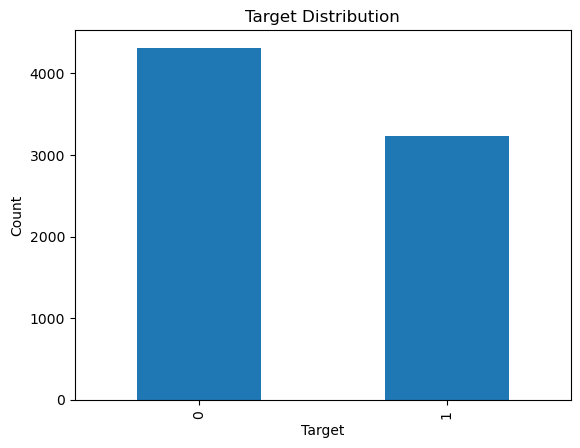

In [39]:
# Target Distribution
plt.figure()
train_noConflict["target"].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

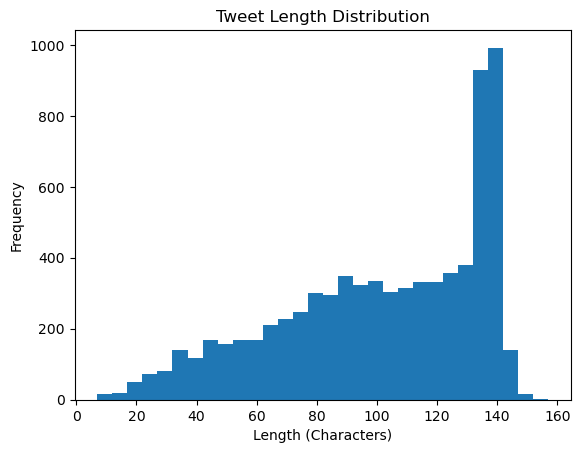

In [40]:
# Tweet Lengths
train_noConflict["text_length"] = train_noConflict["text"].str.len()
plt.figure()
plt.hist(train_noConflict["text_length"], bins = 30)
plt.title("Tweet Length Distribution")
plt.xlabel("Length (Characters)")
plt.ylabel("Frequency")
plt.show()

<Figure size 640x480 with 0 Axes>

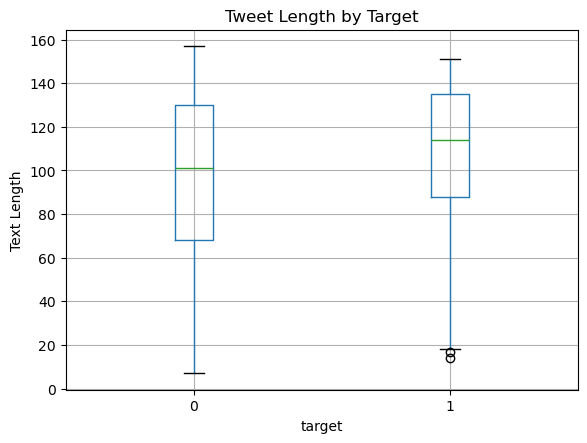

In [41]:
# Length by Target Class
plt.figure()
train_noConflict.boxplot(column="text_length", by = "target")
plt.suptitle("")
plt.title("Tweet Length by Target")
plt.xlabel("target")
plt.ylabel("Text Length")
plt.show()

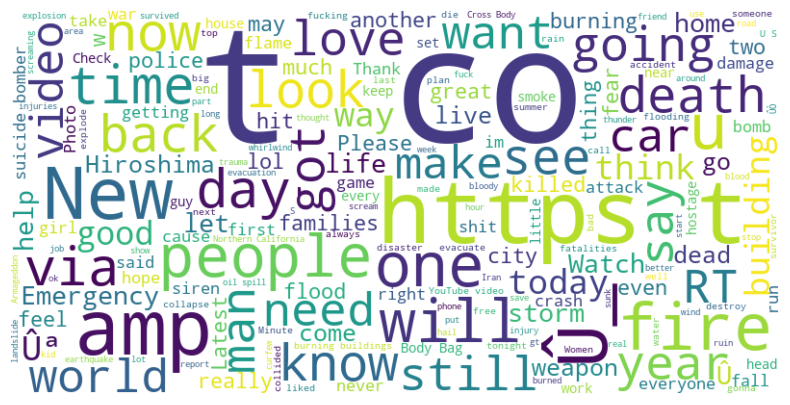

In [42]:
# Wordcloud
word_cloud = WordCloud(width = 800, height=400, background_color="white").generate(" ".join(train_noConflict["text"].tolist()))
plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [43]:
# Top 20 Unigrams
vec_uni = CountVectorizer(ngram_range=(1,1), stop_words="english")
X_uni = vec_uni.fit_transform(train_noConflict["text"])
uni_freqs = list(zip(vec_uni.get_feature_names_out(), X_uni.sum(axis=0).A1))
top_unigrams = pd.DataFrame(uni_freqs, columns = ["unigram", "frequency"]).nlargest(20, "frequency").reset_index(drop=True)
display(top_unigrams)

# Top 20 Bigrams
vec_uni = CountVectorizer(ngram_range=(2,2), stop_words="english")
X_uni = vec_uni.fit_transform(train_noConflict["text"])
uni_freqs = list(zip(vec_uni.get_feature_names_out(), X_uni.sum(axis=0).A1))
top_bigrams = pd.DataFrame(uni_freqs, columns = ["bigram", "frequency"]).nlargest(20, "frequency").reset_index(drop=True)
display(top_bigrams)


,unigram,frequency
0,http,4288
1,https,407
2,like,347
3,amp,343
4,û_,339
5,just,323
6,new,226
7,news,196
8,people,196
9,don,186


,bigram,frequency
0,û_ http,214
1,burning buildings,60
2,suicide bomber,54
3,youtube video,43
4,liked youtube,42
5,video http,42
6,northern california,41
7,cross body,40
8,oil spill,39
9,suicide bombing,35


As part of this previous section the data were inspected and duplicate and contradicting tweets have been dropped. Additionally, we showed that there exist NaN values in the rows corresponding to keyword and location, these will need to be dealt with. As part of the following section, I will be preprocessing the data. 

## Step 3: Model Architecture
#### Step 3.1 Data Preprocessing
- Fill NaN values
- Normalize Tweets (text): lowercase, strip URLs, drop hashtags, convert emojis to text, remove repeated whitespace, remove english stopwords, strip handles
- Lemmatize text: tag the tokens as verbs, nouns, adjectives, adverbs then map each word to WordNet's POS and Lemmatize
- Process Lemmas to Matrix form using TF-IDF


In [44]:
# Replace Empty keywords with "no key"
# Replace empty location with "unknown"

train_clean = train_noConflict.drop(columns="text_length")
train_clean["keyword"] = train_clean["keyword"].fillna("no key")
train_clean["location"] = train_clean["location"].fillna("unknown")
train_clean


,id,keyword,location,text,target
0,1,no key,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,no key,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,no key,unknown,All residents asked to 'shelter in place' are ...,1
3,6,no key,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,no key,unknown,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7538,10869,no key,unknown,Two giant cranes holding a bridge collapse int...,1
7539,10870,no key,unknown,@aria_ahrary @TheTawniest The out of control w...,1
7540,10871,no key,unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7541,10872,no key,unknown,Police investigating after an e-bike collided ...,1


##### Normalize Tweets
- Lowercase
- Remove URLs
- Convert emojis to text
- Strip spaces
- Strip stopwords

In [45]:
# Normalize Tweets into tokens

nltk.download('stopwords')
tok = TweetTokenizer(preserve_case = False, reduce_len=True, strip_handles=True)
stop = set(stopwords.words("english"))

def clean_and_tokenize(text):
    text = text.lower() # Lowercase
    text = re.sub(r"http\S+|www\.\S+", "", text) # Remove URLs
    text = re.sub(r"#", "", text) # Drop hashtags
    text = emoji.demojize(text, delimiters = (" ", " ")) # Convert emojis to text
    text = re.sub(r"\s+", " ", text).strip()
    tokens = tok.tokenize(text)

    return [t for t in tokens if t.isalpha() and t not in stop]

train_clean["tokens"] = train_clean["text"].apply(clean_and_tokenize)
train_clean

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timseidel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,tokens
0,1,no key,unknown,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,no key,unknown,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,no key,unknown,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,no key,unknown,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,no key,unknown,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...
7538,10869,no key,unknown,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, bridge, collapse..."
7539,10870,no key,unknown,@aria_ahrary @TheTawniest The out of control w...,1,"[control, wild, fires, california, even, north..."
7540,10871,no key,unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[utc, volcano, hawaii]"
7541,10872,no key,unknown,Police investigating after an e-bike collided ...,1,"[police, investigating, collided, car, little,..."


##### Lemmatization:
Reduce words to their core meanning, whilst obtaining their complete english word instead of just a fragment as a result of stemming.

In [46]:
# Lemmatize tokens 

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else: 
        return wordnet.NOUN

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization function
def lemmatize_tokens(tokens):
    pos_tags = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(tok, get_wordnet_pos(tag))
        for tok, tag in pos_tags
    ]

# Apply to your DataFrame (assuming you have a 'tokens' column)
train_clean["lemmas"] = train_clean["tokens"].apply(lemmatize_tokens)
train_clean



,id,keyword,location,text,target,tokens,lemmas
0,1,no key,unknown,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,4,no key,unknown,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,no key,unknown,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o...","[resident, ask, shelter, place, notify, office..."
3,6,no key,unknown,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,..."
4,7,no key,unknown,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...
7538,10869,no key,unknown,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, bridge, collapse...","[two, giant, crane, hold, bridge, collapse, ne..."
7539,10870,no key,unknown,@aria_ahrary @TheTawniest The out of control w...,1,"[control, wild, fires, california, even, north...","[control, wild, fire, california, even, northe..."
7540,10871,no key,unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[utc, volcano, hawaii]","[utc, volcano, hawaii]"
7541,10872,no key,unknown,Police investigating after an e-bike collided ...,1,"[police, investigating, collided, car, little,...","[police, investigate, collide, car, little, po..."


#### Step 3.2 Build and Train Sequential Neural Nets
- Step 3.2.1: Bidirectional LSTM Network with lemmatized tweets -> integer matrix
- Step 3.2.2: Bidirectional LSTM Network with Word2Vec

For both models I shall One-Hot Encode "Keyword" and "Location":
- Given the "Keyword" and "Location" have no meanigful order (are ordinal data), one-hot encoding is ideal because it treats every category as equally distinct. 

In [47]:
print("MPS available:", tf.config.list_physical_devices("GPU"))

MPS available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 3.2.1 Bidirectional LSTM Network without Word2Vec

Epoch 1/10
95/95 - 6s - loss: 0.5852 - accuracy: 0.6800 - precision: 0.7783 - recall: 0.3533 - val_loss: 0.4456 - val_accuracy: 0.7952 - val_precision: 0.7871 - val_recall: 0.7152 - 6s/epoch - 63ms/step
Epoch 2/10
95/95 - 3s - loss: 0.3273 - accuracy: 0.8709 - precision: 0.8781 - recall: 0.8111 - val_loss: 0.4560 - val_accuracy: 0.8025 - val_precision: 0.8199 - val_recall: 0.6904 - 3s/epoch - 28ms/step
Epoch 3/10
95/95 - 2s - loss: 0.2093 - accuracy: 0.9263 - precision: 0.9414 - recall: 0.8827 - val_loss: 0.5430 - val_accuracy: 0.7860 - val_precision: 0.7931 - val_recall: 0.6765 - 2s/epoch - 26ms/step
Epoch 4/10
95/95 - 2s - loss: 0.1491 - accuracy: 0.9508 - precision: 0.9628 - recall: 0.9207 - val_loss: 0.6141 - val_accuracy: 0.7700 - val_precision: 0.7282 - val_recall: 0.7384 - 2s/epoch - 25ms/step
val_acc=0.795 | val_prec=0.787 | val_rec=0.715


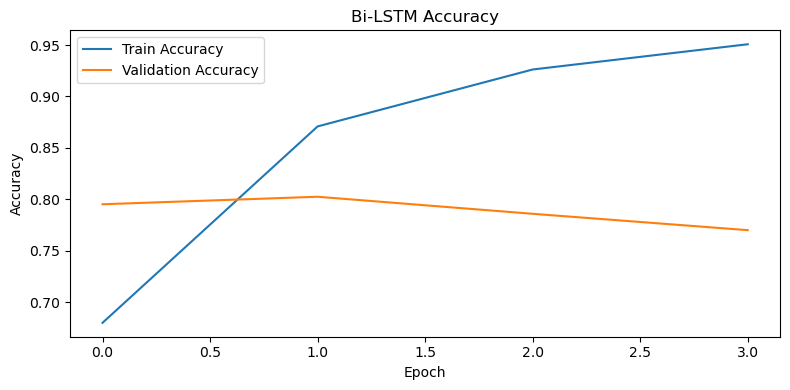

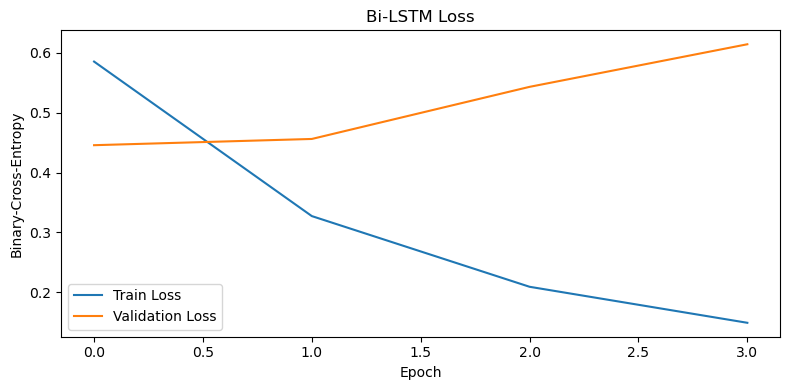

In [ ]:
max_vocab = 20000
max_len = 40
embed_dim = 128

# Text -> Integer ID's
tokenizer = Tokenizer(num_words = max_vocab, oov_token = "<UNK>")
tokenizer.fit_on_texts(train_clean["lemmas"])

X_seq = pad_sequences(tokenizer.texts_to_sequences(train_clean["lemmas"]), maxlen=max_len, truncating = "post")

# One-Hot Encoding Keyword and Location
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(train_clean[["keyword", "location"]])

X_meta = ohe.transform(train_clean[["keyword", "location"]]).astype("float32")

# Train / Validation Split
target = train_clean["target"].values
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_seq, X_meta, target, test_size=0.2, stratify = target, random_state = 42
)

# Build Dual Input (Features and Metadata) Bidirectional-LSTM Model
text_in = tf.keras.Input(shape=(max_len,), name="text_ids")
meta_in = tf.keras.Input(shape=(X_meta.shape[1],), name = "meta_ohe")

x = tf.keras.layers.Embedding(input_dim = max_vocab, output_dim=embed_dim)(text_in)

# In order to use the fast cuDDN kernel, I shall not use dropout or recurrent_dropout
# This significantly speeds up training but can lead to overfitting
x = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, dropout=0.0, recurrent_dropout=0.0))(x)

combined = tf.keras.layers.concatenate([x, meta_in])

hidden = tf.keras.layers.Dense(
    32, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(1e-4))(combined)

hidden = tf.keras.layers.Dropout(0.5)(hidden)

output = tf.keras.layers.Dense(1, activation = "sigmoid")(hidden)
model = tf.keras.Model(inputs=[text_in, meta_in], outputs=output)

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy", 
               tf.keras.metrics.Precision(name = "precision"),
               tf.keras.metrics.Recall(name="recall")]
)

# Implement Early Stopping to catch Overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 3, restore_best_weights = True)

# Train
history = model.fit(
    {"text_ids": X_seq_train, "meta_ohe": X_meta_train},
    y_train,
    validation_data=({"text_ids": X_seq_val, "meta_ohe": X_meta_val}, y_val),
    epochs = 10, batch_size = 64,
    callbacks = [early_stop], verbose = 2
)

# Evaluate
loss, acc, prec, rec = model.evaluate(
    {"text:ids": X_seq_val, "meta_ohe": X_meta_val},
    y_val, verbose = 0
)
print(f"val_acc={acc:.3f} | val_prec={prec:.3f} | val_rec={rec:.3f}")

# Plot Accuracies and Losses
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.xlable("Epoch")
plt.ylabler("Accuracy")
plt.title("Bi-LSTM Accuracy")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.xlable("Epoch")
plt.ylabler("Binary-Cross-Entropy")
plt.title("Bi-LSTM Loss")
plt.legend()
plt.tight_layout()
plt.show()

##### Analysis & Interpretation
1. Train: 
- Accuracy climbs sharply from 0.68 to 0.95 after the 4th epoch
- Loss falls sharply, from 0.58 to 0.15 
2. Validation:
- Accuracy peaks at around 0.8 after the second epoch, then trends downward
- Loss drops marginally at first and then increases with each epoch -> model is fitting noise

Interpretation:
Overfitting onset happens early after the second epoch. By the 4th epoch, the models has specialized on the training set but fails to generalize on the validation set. The trend is likely to have continued, if the early stopping criterion of 3 subsequent epochs with higher val_loss were to have been 4 or higher. 

##### Recommendations for Improvement
- Regularization: increase dropout rate. Given that the goal in this training cycle was to use the cuDDN kernel dropout was deliberately not used in the first layer
- Implement Word2Vec: acts as another powerful form of regularization. Given that embeddings are trained on a very large corpus, the model will no longer be tasked with having to rediscover basis word co-occurence patterns and can instead focues on high-level patterns. Although it effectively reduces the trainable parameters of the model, which leads to lower variance and thus less risk of fitting noise. 


#### 3.2.2 Bidirectional LSTM with Word2Vec
The following implementation makes use of the recommendations to improve training. 

##### Word2Vec Explanation
Word2Vec is a shallow-neural networok that turns each word in a corpus into a fixe-length numerical vector (embedding). It captures the word's meaning through the contexts in which it appears. Context refers to the group of words that sorround a given word. Via this process, words with similar meanings are clustered closely together. 

Essentially, it is a two layer Neural Network where each unique word in the data gets assigned a vector, whose position is determined via the words' semantic meaning and closeness to other words. 

Word2Vec has two variants: Continuous Bag of Words and Continuous Skip-Gram Model
- Continuous Bag of Words (CBOW): tries to predict the target word via the context. 
- Continuous Skip-Gram Model: tries to predict the context via the target word.

Below, I shall implement the Skip-Gram variant because it works better with rare words and is more flexible to linguistic context. Given that tweets don't follow a clear structure and are known to contain words that are less common, it makes sense to use Skip-Gram. 

However, Skip-Gram is significantly more computationally complex than CBOW because it must predict multiple words from one target word. 

Epoch 1/10
95/95 - 293s - loss: 0.6073 - accuracy: 0.6677 - precision: 0.6706 - recall: 0.4404 - val_loss: 0.5179 - val_accuracy: 0.7594 - val_precision: 0.8223 - val_recall: 0.5588 - 293s/epoch - 3s/step
Epoch 2/10
95/95 - 284s - loss: 0.5301 - accuracy: 0.7468 - precision: 0.7571 - recall: 0.6018 - val_loss: 0.5084 - val_accuracy: 0.7594 - val_precision: 0.8477 - val_recall: 0.5341 - 284s/epoch - 3s/step
Epoch 3/10
95/95 - 285s - loss: 0.4999 - accuracy: 0.7637 - precision: 0.7736 - recall: 0.6335 - val_loss: 0.5010 - val_accuracy: 0.7647 - val_precision: 0.8575 - val_recall: 0.5402 - 285s/epoch - 3s/step
Epoch 4/10
95/95 - 296s - loss: 0.4762 - accuracy: 0.7844 - precision: 0.7999 - recall: 0.6622 - val_loss: 0.4871 - val_accuracy: 0.7734 - val_precision: 0.8408 - val_recall: 0.5805 - 296s/epoch - 3s/step
Epoch 5/10
95/95 - 304s - loss: 0.4547 - accuracy: 0.7965 - precision: 0.8171 - recall: 0.6761 - val_loss: 0.4782 - val_accuracy: 0.7840 - val_precision: 0.8175 - val_recall: 0.637

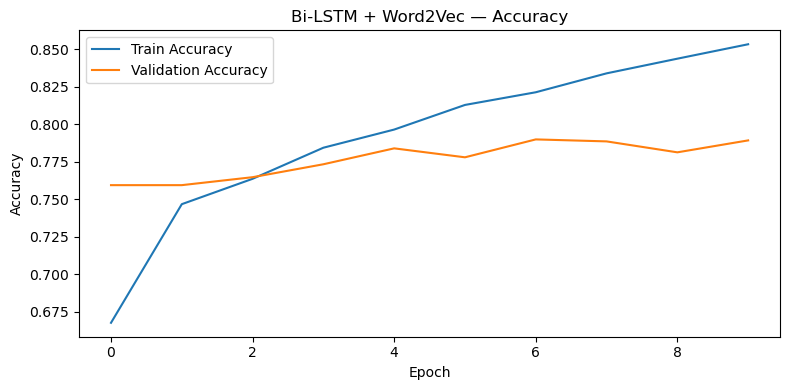

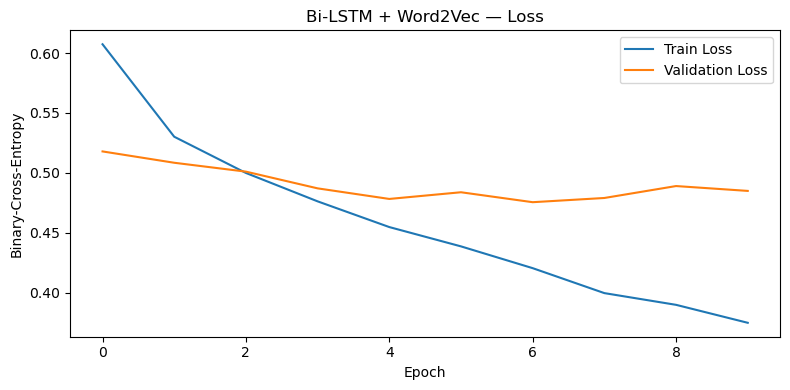

In [ ]:
# Hyperparameters
MAX_VOCAB = 20000
MAX_LEN = 40
EMB_DIM = 128
MIN_COUNT = 3
W2V_EPOCHS = 10

# Tokenize Lemmas -> integer ids

sentences = [lem if isinstance(lem, list) else lem.split()
             for lem in train_clean["lemmas"]]

lemmas_txt = [" ".join(lem) if isinstance(lem, list) else lem
              for lem in train_clean["lemmas"]]

tokenizer = Tokenizer(num_words = MAX_VOCAB, oov_toker = "<UNK>")
tokenizer.fit_on_texts(lemmas_txt)

X_seq = pad_sequences(tokenizer.texts_to_sequences(lemmas_txt), maxlen = MAX_LEN, truncating = "post")

# Word2Vec
w2v = Word2Vec(sentences, vector_size=EMB_DIM, window = 5, min_count = MIN_COUNT, sg = 1,
               negative = 10, epochs = W2V_EPOCHS, workers = 4)

# Build idx -> vector matrix to align with the Keras Tokenizer
vocab_size = min(MAX_VOCAB, len(tok.word_index) + 1)
emb_matrix = np.random.normal(0, 0.6, (vocab_size, EMB_DIM)).astype("float32")

for word, idx in tokenizer.word_index.items():
    if idx < MAX_VOCAB and word in w2v.wv:
        emb_matrix[idx] = w2v.wv[word]

# One-Hot Encoding Keyword and Location
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(train_clean[["keyword", "location"]])

X_meta = ohe.transform(train_clean[["keyword", "location"]]).astype("float32")

# Train / Validation Split
target = train_clean["target"].values
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_seq, X_meta, target, test_size=0.2, stratify = target, random_state = 42
)

# Build Dual Input (Features and Metadata) Bidirectional-LSTM Model
text_in = tf.keras.Input(shape=(max_len,), name="text_ids")
meta_in = tf.keras.Input(shape=(X_meta.shape[1],), name = "meta_ohe")

x = tf.keras.layers.Embedding(
    input_dim = vocab_size,
    output_dim = EMB_DIM,
    weights = [emb_matrix],
    input_length = max_len,
    trainable = False
)(text_in)

x = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3))(x)

merged = tf.keras.layers.concatenate([x, meta_in])
hid = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(1e-4))(merged)
hid = tf.keras.layers.Dropout(0.5)(hid)
out = tf.keras.layers.Dense(1, activation = "sigmoid")(hid)

model = tf.keras.Model(inputs=[text_in, meta_in], outputs = out)

model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accurarcy",
                                                                         tf.keras.metrics.Precision(name="precision"),
                                                                         tf.keras.metrics.Recall(name="recall")])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights =True)

# Train
history = model.fit(
    {"text_ids": X_seq_train, "meta_ohe": X_meta_val},
    y_train,
    validation_data=({"text_ids": X_seq_val, "meta_ohe": X_meta_val}, y_val),
    epochs=10, batch_size=64,
    callbacks=[early_stop], verbose=2)

# Evaluate
loss, acc, prec, rec = model.evaluate(
    {"text_ids": X_seq_val, "meta_ohe": X_meta_val},
    y_val, verbose=0)
print(f"val_acc={acc:.3f} | val_prec = {prec:.3f} | val_rec = {rec:.3f}")

# Plot Accuracy and Loss vs. Epochs
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Bi-LSTM + Word2Vec - Accuracy")
plt.legend(),
plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary-Cross-Entropy")
plt.title("Bi-LSTM + Word2Vec - Loss")
plt.legend()
plt.tight_layout()
plt.show()

##### Analysis and Interpretation
1. Training:
Accuracy climbs steadily over 10 epochs, while loss falls
2. Validation:
Accuracy starts around 0.76 and edges up to around 0.79 and drifts slightly back down to 0.78.

The early stopping criterion of 3 is not reached after 10 epochs, yet the pattern suggests that the model has begun to overfit slightly because validation loss has plateaued while train loss continues to decrease. 

The improvements to the model have significantly improved generalization over the first model which was trained in step 3.2.1

## Step 4: Hyperparameter Tuning + Results & Analysis


Trial 30 Complete [00h 49m 08s]
val_accuracy: 0.7945659160614014

Best val_accuracy So Far: 0.8091451525688171
Total elapsed time: 1d 01h 47m 18s



BEST model: acc=0.809 | prec=0.829 | rec=0.698
Chosen HP: {'lstm_units': 32, 'dense_units': 64, 'dropout': 0.30000000000000004, 'rec_dropout': 0.4, 'embed_trainable': True, 'lr': 0.0008830228029672759, 'tuner/epochs': 12, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


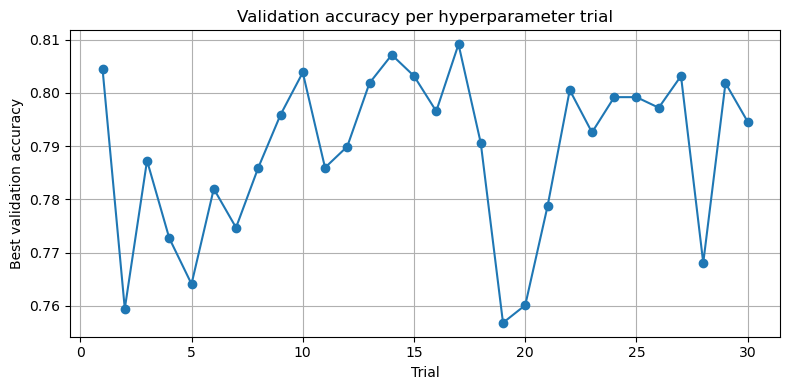

In [ ]:
def build_model(hp: kt.HyperParameters) -> tf.keras.Model:
    lstm_units= hp.Choise("lstm_units", [32, 64, 128])
    dense_units = hp.Choice("dense_units", [16, 32, 64])
    drop_rate = hp.Float("dropout", 0.0, 0.5, step = 0.1)
    rec_drop = hp.Float("rec_dropout", 0.0, 0.5, step = 0.1)
    embed_train = hp.Boolean("embed_trainable")
    lr = hp.Float("lr", 1e-4, 3e-3, samppling="log")

    # Dual Inputs
    txt = tf.keras.Input(shape=(MAX_LEN,), name="text_ids")
    meta = tf.keras.Input(shape=(X_meta_train.shape[1],), name="meta_ohe")

    x = tf.keras.layers.Embedding(
        input_dim = vocab_size, 
        output_dim = EMB_DIM,
        weights = [emb_matrix],
        input_length = MAX_LEN,
        trainable = embed_train)(txt)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, dropout=drop_rate, recurrent_dropout=rec_drop))(x)

    x = tf.keras.layers.concatenate([x, meta])
    x = tf.keras.layers.Dense(dense_units, activation = "relu",
                            kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)

    out = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
    model = tf.keras.Model(inputs=[txt, meta], outputs=out)

    opt = legacy.Adam(learning_rate=lr)

    model.compile(
        optimizer = opt, 
        loss = "binary_crossentropy",
        metrics = ["accurarcy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])
    
    return model

# Callbacks + early stopping
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_word2vec_bilstm.h5", monitor="val_accuracy",
    mode = "max", save_best_only = True, verbose = 0
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience = 3, restore_best_weights = True)

# Hyperband Tuner using pre-split data
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_accuracy", "max"),
    max_epochs=12, factor=3,
    directory = "tuner_out", project_name = "w2v_bilstm"
)

tuner.search(
    {"text_ids": X_seq_train, "meta_ohe": X_meta_train}, y_train,
    validation_data = ({"text_ids": X_seq_valm "meta_ohe": X_meta_val}, y_val),
    callbacks = [early, ckpt],
    verbose = 1
)

# Best Model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

loss, acc, prec, rec = best_model.evaluate(
    {"text_ids": X_seq_val, "meta_ohe": X_meta_val}, y_val, verbose = 0)
print(f"\nBEST model: acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f}")
print("Chosen HP:", best_hp.values)

# Plot validation accuracies per trial
trial_accs = [t.metrics.get_best_value("val_accuracy")
              for t in tuner.oracle.trials.values()]

plt.figure(figsize=(8,4))
plt.plt(range(1, len(trial_accs)+1), trial_accs, marker ="o")
plt.xlabel("Trial")
plt.ylabel("Best validation accuracy")
plt.title("Validation accuracy per hyperparameter trial")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Step 4.1 Analysis, Summary and Interpretation of Hyperparameter Study
The best trial yielded a validation accuracy of roughly 0.809 under consideration of the following hyperparameters: 
{
  "lstm_units": 32,
  "dense_units": 64,
  "dropout": 0.3,
  "rec_dropout": 0.4,
  "embed_trainable": true,
  "lr": 8.8e-4
}

- The small lstm units of 32 proved enough capacity to capture the signal without overfitting as quickly as the larger unit variants. 
- The moderate dropout of 0.3 combined with slightly larger recurrent dropout of 0.4 was a good regularization balance
- Allowing the model to fine tune the embeddings with embed_trainable=true gave the network just enough flexibility to adapt Word2Vec vectors to the specific disaster-tweet domain
- The low learning rate allowed for more stable training without overshooting

The opposite of these values lead to poorer results. Yet all trials oscillated between approx. 0.76 and 0.81 validation accuracy. 

While tuning took in excess of 24 hours, tuning without the hyperband multi-fidelity strategy would have yielded 648 trials instead of 30, without considering the learning rate which was a log-sampled float. 

##### Hyperparameter Tuning Procedure: 
I precomputed X_seq_tr, X_seq_val, etc. in the training step which preceeded via the Tokenizer and OneHotEncoder and then hyperparameter tuned only on the model-size utlizing the precomputed values. This is a more efficient method. 

## Step 5: Conclusion

In [ ]:
# Hyperparameter paths
MAX_VOCAB = 20000
MAX_LEN = 40
MODEL_PATH = "best_word2vec_bilstm.h5"

# Fit the Tokenizer on training lemmas
texts_for_tok = [" ".join(lem) for lem in train_clean["lemmas"]]
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(texts_for_tok)

# Fit the OneHotEncoder on (keyword, location)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(train_clean[["keyword","location"]])

# Define the same cleaning/tokenizing/lemmatizing functions
tok = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"#", "", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = tok.tokenize(text)
    return [t for t in tokens if t.isalpha() and t not in stop]

def get_wordnet_pos(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    return [lemmatizer.lemmatize(tok, get_wordnet_pos(tag))
            for tok, tag in tagged]

# Preprocess TEST
test["keyword"] = test["keyword"].fillna("no key")
test["location"] = test["location"].fillna("unknown")

# Clean, tokenize and lemmatize
test["tokens"] = test["text"].astype(str).apply(clean_and_tokenize)
test["lemmas"] = test["tokens"].apply(lemmatize_tokens)

texts = [" ".join(l) for l in test["lemmas"]]
seqs = tokenizer.texts_to_sequences(texts)
X_seq = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

X_meta = ohe.transform(test[["keyword","location"]].values)

# Load model & predict
model = load_model(MODEL_PATH)
y_prob = model.predict(
    {"text_ids": X_seq, "aux_ohe": X_meta},
    batch_size=64, verbose=1
)
y_pred = (y_prob >= 0.4).astype(int)

test["target_prob"]  = y_prob.flatten()
test["target"] = y_pred.flatten()
test[["id","target"]].to_csv("submission.csv", index=False)

print("Submission file written.")

/opt/anaconda3/envs/nlp_safe/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


51/51 [==============================] - 13s 167ms/step
Submission file written.


#### Step 5.1 Analysis, Conclusion and Improvements for the future

Having reloaded the best model from the hyperparameter study and performed preprocssing on the test data including one-hot encoding as well as tokenization according to the same procedure as in training, the model was used to predict on the test set. 

I then proceeded to upload the submission file to kaggle and obtained a score of 0.63101 as can be seen in the leaderboard position below. 
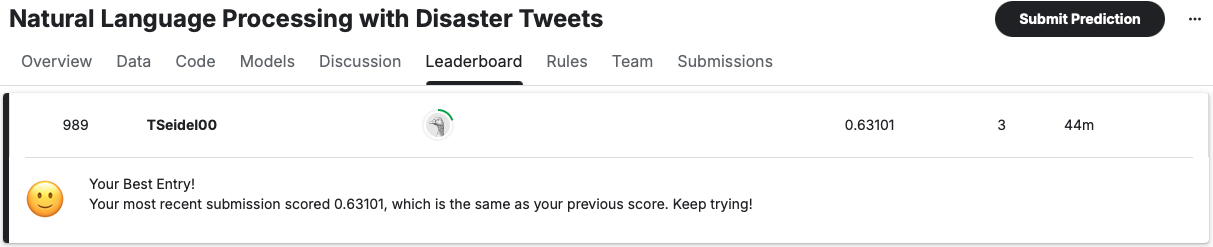

As such the drop from the validation accuracy of 0.8 to approximately 0.63 is quite large, but could be attributed to the following: 
- Domain / Distribution shift: perhaps the test tweets contained somewhat different slang or noise patterns
- Metadat signal lost on test: given that I filled NaN values but did not add another column specifying a missing indicator. This may have helped the model to decide whether or not to trust the metadata. 

Another issue which proved to hold true was the threshold calibration. Initially, I fixed a 0.5 cutoff on the sigmoid output which yielded the 0.63101 result. The optimal decision threshold may be different. After testing a 0.4 cutoff the prediction accuracy rose to 0.66319 as can be seen in the following screenshot: 
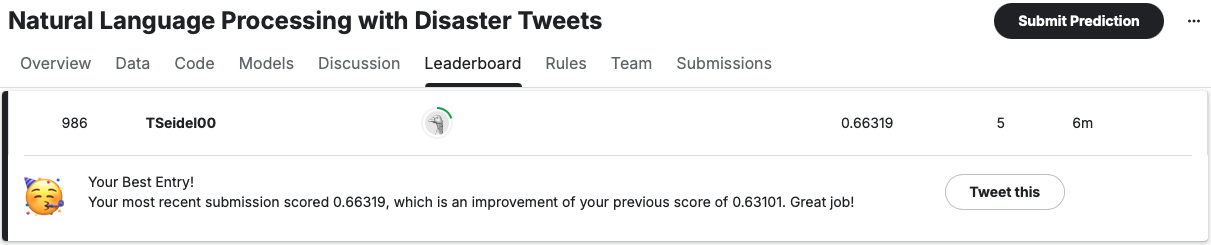

##### Improvements for the Future
- I could perform an error analysis by sampled 100 tweets the model got wrong to look for common patterns. This would guide a decision on whether more data augmentation could provide benefits or new features need to be introduced through data engineering. 
- I could perform cross-validation ensembling instead of using a single best model. Hence, try k-folg CV and average the predicitons. This reduces variance tied to one particular train/val split. 

## Bibliography


- “Word2vec.” TensorFlow, www.tensorflow.org/text/tutorials/word2vec.
- Lang, Niklas. “What Is Word2Vec? | Data Basecamp.” Data Basecamp, 21 Feb. 2024, databasecamp.de/en/ml/word2vec-en.
- Lang, Niklas. “Long Short-Term Memory Networks (LSTM)- Simply Explained! | Data Basecamp.” Data Basecamp, 13 May 2023, databasecamp.de/en/ml/lstms.
- Murel, Jacob, PhD, and Eda Kavlakoglu. “Stemming and Lemmatization.” IBM - Artificial Intelligence, 17 Apr. 2025, www.ibm.com/think/topics/stemming-lemmatization.